In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [4]:
class NeuralNet:
   
    def __init__(self, normalize = True, learning_rate = 0.01, num_iter = 30000, hidden_layer_sizes =(4,4), tol=1e-6, notimp_iters=200 ):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.hidden_layer_sizes =hidden_layer_sizes;
        self.tol =tol;
        self.num_layers =len(hidden_layer_sizes);
        self.notimp_iters = notimp_iters
        
        
    def __softmax(self, Z):
        return np.exp(Z)/np.sum(np.exp(Z))
        
    
    def __normalize(self, X, mean = None, std = None):
    
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    
    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    
    def __initialize_parameters(self, n_x, n_arr):
        W_arr =[];
        b_arr =[];
       
        W1 = np.random.randn(n_arr[0], n_x)*0.01;
        b1 = np.zeros((n_arr[0], 1));
        W_arr.append(W1);
        b_arr.append(b1);
        
        for n_l in range(1,len(n_arr)):
            W_temp =np.random.randn(n_arr[n_l], n_arr[n_l-1]) * 0.01;
            b_temp = np.zeros((n_arr[n_l], 1));
            W_arr.append(W_temp);
            b_arr.append(b_temp);
        
        W2 =np.random.randn(1, n_arr[len(n_arr)-1]) * 0.01
        b2 = 0;
        
        W_arr.append(W2);
        b_arr.append(b2);
    
        self.parameters = {"W_arr" : W_arr, "b_arr" : b_arr}
       
    
    def __forward_propagation(self, X):
        W_arr =self.parameters["W_arr"]
        b_arr = self.parameters["b_arr"]
        
        W1 = W_arr[0];
        b1 = b_arr[0];
        
        W2 =W_arr[len(W_arr)-1];
        b2 =b_arr[len(b_arr)-1];
        
        Z_arr =[];
        A_arr =[];
        
        Z1 =np.dot(W1,X)+b1;
        A1 = self.__sigmoid(Z1);
        
        Z_arr.append(Z1);
        A_arr.append(A1);
        
        for l in range(1,self.num_layers):
            Z_temp = np.dot(W_arr[l],A_arr[l-1])+b_arr[l];
            A_temp = self.__sigmoid(Z_temp);
            Z_arr.append(Z_temp);
            A_arr.append(A_temp);

        Z_temp = np.dot(W_arr[self.num_layers],A_arr[self.num_layers-1])+b_arr[self.num_layers];
        A_temp = self.__softmax(Z_temp);
        Z_arr.append(Z_temp);
        A_arr.append(A_temp);
        cache =(W_arr,b_arr,Z_arr,A_arr);
        return A_arr[-1], cache
    
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
 
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W_arr,b_arr,Z_arr,A_arr) = cache

        dZ_arr=[];
        dW_arr =[];
        dA_arr=[];
        db_arr =[];
        
        dZ2 = A_arr[-1] -Y;
        dW2 = 1. / m * np.dot(dZ2, A_arr[-2].T);
        db2 =1. / m * np.sum(dZ2, axis = 1, keepdims = True);
        dA2 =np.dot(W_arr[-1].T,dZ2);
        dZ_arr.insert(0,dZ2); 
        dW_arr.insert(0,dW2);
        db_arr.insert(0,db2);
        dA_arr.insert(0,dA2);
             
        for l_inv in range(len(W_arr)-2,0,-1):
            dZ_temp =np.multiply(dA_arr[0], np.multiply(A_arr[l_inv], 1 - A_arr[l_inv]));
            dW_temp =1. / m * np.dot(dZ_temp, A_arr[l_inv-1].T);
            db_temp =1. / m * np.sum(dZ_temp, axis = 1, keepdims = True);
            dA_temp =np.dot(W_arr[l_inv].T,dZ_temp);
            dZ_arr.insert(0,dZ_temp);
            dW_arr.insert(0,dW_temp);
            dA_arr.insert(0,dA_temp);
            db_arr.insert(0,db_temp);
        
       
        dA1 =dA_arr[0];
        dZ1 = np.multiply(dA1, np.multiply(A_arr[0], 1 - A_arr[0]));
        dW1 = 1. / m * np.dot(dZ1, X.T)
        db1 =1. / m * np.sum(dZ1, axis = 1, keepdims = True)
        dZ_arr.insert(0,dZ1)
        dW_arr.insert(0,dW1)
        db_arr.insert(0,db1)
        grads ={"dZ_arr":dZ_arr,"dW_arr":dW_arr,"db_arr":db_arr}
        return grads
    
        
    def __update_parameters(self, grads):
        W_arr =self.parameters["W_arr"];
        b_arr =self.parameters["b_arr"];
        dW_arr =grads["dW_arr"];
        db_arr =grads["db_arr"];
        
        Wnew =W_arr.copy();
        bnew = b_arr.copy();
        for l in range(0,len(W_arr)):
            Wnew[l]-=self.learning_rate * dW_arr[l];
            bnew[l]-=self.learning_rate * db_arr[l];
        self.parameters["W_arr"] = Wnew;
        self.parameters["b_arr"] = bnew;
        
        
    def fit(self, X_vert, Y_vert, print_cost = True):
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        improve_costs =[]
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters(n_x,self.hidden_layer_sizes)

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)
            cost = self.compute_cost(A, Y)
            grads = self.__backward_propagation(X, Y, cache)
            self.__update_parameters(grads)
            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))
            if i % 1000 == 0:
                costs.append(cost)
                
            if i%self.notimp_iters ==0:
                improve_costs.append(cost);
                if len(improve_costs) >2:
                    if abs(improve_costs[len(improve_costs)-1] - improve_costs[len(improve_costs)-2]) < self.tol:
                        return;
        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        probs = self.__forward_propagation(X)[0]
        return np.column_stack((probs.T, 1 - probs.T))
    
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)


In [5]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


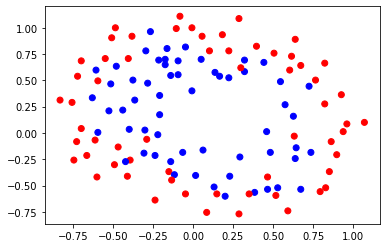

In [6]:
plot_data(X, Y)

In [7]:
cls = NeuralNet(normalize = True, 
                learning_rate = 0.001, 
                num_iter = 10001,
                hidden_layer_sizes = (7,2),
                notimp_iters=100000,
                tol=1e-8)

0-th iteration: 2.3492402254087588
1000-th iteration: 2.3492390468182287
2000-th iteration: 2.3492381568711687
3000-th iteration: 2.3492370414393786
4000-th iteration: 2.3492310367636606
5000-th iteration: 2.3492075502940164
6000-th iteration: 2.3491536230143484
7000-th iteration: 2.3490724670418754
8000-th iteration: 2.34898192897001
9000-th iteration: 2.3488984397975963
10000-th iteration: 2.3488297953263513


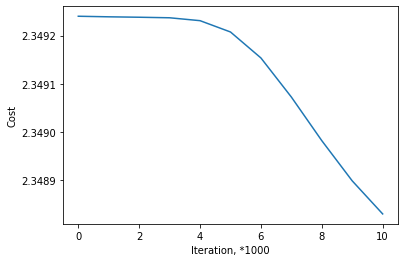

In [8]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [9]:
print(cls.parameters)

{'W_arr': [array([[ 0.00568992, -0.00488071],
       [-0.01580782,  0.00305286],
       [-0.0291837 , -0.02195033],
       [-0.00678906,  0.00385621],
       [-0.02329049,  0.01289638],
       [-0.02379932,  0.00983593],
       [-0.02213157, -0.0134643 ]]), array([[0.47759621, 0.50148662, 0.50516162, 0.47851357, 0.4879217 ,
        0.48735108, 0.50132743],
       [0.48238914, 0.49586702, 0.52036105, 0.47416543, 0.49761068,
        0.49176288, 0.49312675]]), array([[3.48458137, 3.50560546]])], 'b_arr': [array([[0.11195656],
       [0.12045611],
       [0.12686268],
       [0.11015961],
       [0.11761798],
       [0.11612805],
       [0.1197232 ]]), array([[0.9658094 ],
       [0.97019211]]), array([[4.83099153]])]}


In [10]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[0.00840981, 0.99159019],
       [0.0084178 , 0.9915822 ],
       [0.00862411, 0.99137589],
       [0.00849133, 0.99150867],
       [0.00857223, 0.99142777],
       [0.00854391, 0.99145609],
       [0.00861562, 0.99138438],
       [0.00834721, 0.99165279],
       [0.0083691 , 0.9916309 ],
       [0.00854457, 0.99145543],
       [0.00847986, 0.99152014],
       [0.00856647, 0.99143353],
       [0.00839316, 0.99160684],
       [0.00846221, 0.99153779],
       [0.00851956, 0.99148044],
       [0.00838913, 0.99161087],
       [0.00860013, 0.99139987],
       [0.00837164, 0.99162836],
       [0.00849264, 0.99150736],
       [0.00844777, 0.99155223],
       [0.00849679, 0.99150321],
       [0.00856263, 0.99143737],
       [0.00858312, 0.99141688],
       [0.00847276, 0.99152724],
       [0.00859143, 0.99140857],
       [0.00850546, 0.99149454],
       [0.00860369, 0.99139631],
       [0.00854431, 0.99145569],
       [0.00847067, 0.99152933],
       [0.00845256, 0.99154744],
       [0.

In [11]:
Y_hat = cls.predict(X)
Y_hat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [12]:
accuracy_score(Y, Y_hat)

0.5084745762711864

<ipython-input-2-1d8d12161a03>:10: UserWarning: No contour levels were found within the data range.
  ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')


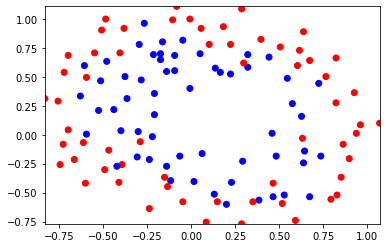

In [13]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

In [14]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (5,10,), 
                    max_iter = 10000, 
                    activation = 'relu', 
                    solver = 'sgd', 
                    learning_rate_init = 0.01, 
                    learning_rate = 'constant')

In [15]:
clf.fit(X, Y)

MLPClassifier(hidden_layer_sizes=(5, 10), learning_rate_init=0.01,
              max_iter=10000, solver='sgd')

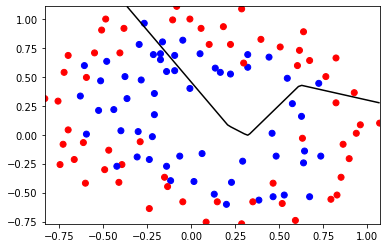

In [16]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [17]:
accuracy_score(Y, clf.predict(X))

0.4661016949152542

In [18]:
clf.n_iter_

110